On explore dans ce Jupyter Notebook la piste dans laquelle nous appliquons l'algorithme de Clustering Meanshift aux vecteurs de 128 dimensions.

# L'algorithme MeanShift 

Meanshift est un algorithme de clustering qui se situe dans le prolongement d'un algorithme ou plutot une methode appellé KDE ( Kernel Density Estimation).L'idée globale de cette algorithme est de trouver une estimation pertinente de la densité de  probabilités qui a généré les données.

![title](mean-shift-and-hierarchical-clustering-8-638.jpg)

## Comment?

Pour estimer la densité de probabilité l'algorithme se base sur une idée très simple qui consiste (grossierement)  à considerer chacun des points disponibles comme repères et indicateurs sur la forme de la densité.En effet, si une zone concentre enormement de points alors dans le voisinage de ces points se trouve surement un des modes de la distribution.


On considere donc chacun des points de nos données comme centre d'une distribution bien choisi que l'on modelise par un Kernel(Noyau).
On obtient l'estimation de la probabilité globale en sommant toutes les contributions des differents points.

![title](Kde.png)

Apres la phase de KDE où on obtient une representation de la distribution globale des données avec l'apparition eventuelle de certains modes.
![image.png](contour.png)



Ces modes representent les clusters identifiés dans nos données.Maintenant il faut rapprocher chacun de nos points d'un de ces clusters pour leur assigner un cluster chacun.

Cette operation se fait de maniere iterative a travers une succession de petits deplacement des points appelé shifting (D'où le nom Meanshift).

![SegmentLocal](shifting.gif)




On voit que nos points se rapprochent des modes trouvés par KDE.

## Quels sont les hyper parametres à ajuster?

### Le Noyau (Kernel):

Il existe plusieurs formes de kernels, pour faire plus simple on peut voir ces kernels comme representant une distance bien precise ou une notion de similarité.
#### Le Noyau Gaussien:
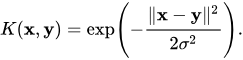
Dans ce cas de figure on modelise donc la distribution de nos données comme une somme de gaussiennes.


C'est ce noyau qui est utilisé dans l'implementation délivrée par Sickit-learn


### La largeur de bande (Brandwidth):

Cet hyper parametre joue un role centrale dans le fonctionnement puisque ce parametre definit l'ecart type de tous les kernels assignés aux points lors de la phase KDE.

Cet ecart type est ce qui permet de definir implicitement le nombre de clusters trouvés à la fin de la KDE.En effet, si la variance est tres petites on a des kernels tres fins dont les supports seront quasiment disjoints et qui ne pourront donc pas definir une distribution d'ensemble coherente lorsqu'ils seront sommés.On obtiendra alors un nombre de clusters egal au nombre de points ce qui n'est pas l'objectif désiré.

Dans l'autre extreme , si nous choisissons une variance trop grande on finira par avoir une distribution final uni-modale et donc nous ne pourrons diviser nos données en Clusters.

Il faut donc bien choisir la largeur de bande de notre algorithme.



## Avantages et inconveniants de Meanshift:

### Avantages:

-L’algorithme Mean shift prend en paramètre que la largeur de bande des noyaux gaussiens, donc est facile à utiliser et à optimiser, en variant cette largeur de bande, on modifie automatiquement le nombre de clusters et ainsi le clustering des points( contrairement à l’algorithme K-means), pour une très basse largeur, l’estimation de la densité des noyaux (KDE) donnera un pic gaussien pour chaque point, et ainsi chaque point aura son propre cluster, dans le cas contraire, pour une largeur de bande élevée, nous aurons un large noyau, et cela engendrera un seul cluster pour tout les points.

-Robuste aux outliers (faux positifs) : avec le modèle gaussien utilisé, les points isolés ou bien les points qui sont loin du cluster principal réel sont facilement détectés comme non-appartenant à ce dernier, et donc exclus du cluster principal estimé lors de la phase de clustering .

### Inconveniants:

-Relativement long 0(n²) : pour un nombre élevé de points, l’algorithme peut être long à exécuter, mais dans le cadre de notre projet, nous dépassons rarement 100 points par dossier, en plus de cela, malgré sa lenteur, le traitement est parallélisable, chaque point peut être traité en parallèle avec les autres points.

-Sensible au fléau de la dimensionnalité : Nous représentons les points en 128 dimensions, ce qui peut être problématique car en haute dimension, la répartition des points ainsi que les distances deviennent contre-intuitives, et vu que notre algorithme calcule majoritairement des distances, cela peut diminuer son efficacité.

## Application de MeanShift sur nos données

On importe les biblio dont on aura besoin.

In [6]:
import numpy as np
import face_recognition
from keras.models import Sequential
from keras.layers import Dense,Dropout
import os
from PIL import Image
import pickle

Using TensorFlow backend.


On import le dictionnaire d'encodages .Ce dictionnaires contient l'encodage  de chacune des images de notre base de données par Face_recognition.

In [7]:
Dict=pickle.load(open("Embedings.pkl",'rb'))

On choisit le dossier de Rafael Benitez qui contient 12 outliers et qui est assez facile à separer comme l'a montré notre analyse.

In [13]:
name="rafael benítez"

num_pictures=len(Dict[name].keys())

X=np.zeros((num_pictures,128))

for i in range(num_pictures):
    
    if Dict[name][i]!=[]:
        
        X[i]=Dict[name][i][0]
    else:
        print("la photo numero "+str(i)+" de "+name+"  genere un encodage vide")
        X[i]=np.zeros((128))



    
    

la photo numero 42 de rafael benítez  genere un encodage vide


On retrouve un des defauts de Face_recognition puisque certaines photos sont identifiés comme ne contenant aucun visage et leur encodage est alors vide.

In [9]:
print("The size of X: ",X.shape)
print("The number of pictures in the folder: ",num_pictures)
print("The output dimension of Face_recognition: ",Dict[name][0][0].shape[0])

The size of X:  (53, 128)
The number of pictures in the folder:  53
The output dimension of Face_recognition:  128


On a 53 photos dans le dossier avec 13 outliers.

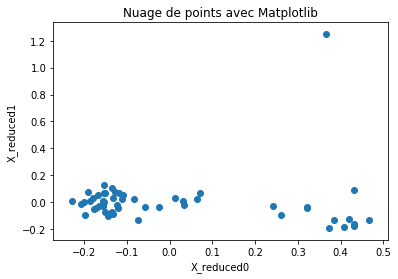

In [15]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca=PCA(n_components=2)
X_reduced=pca.fit_transform(X)

plt.scatter(X_reduced[:,0],X_reduced[:,1])
plt.title('Nuage de points avec Matplotlib')
plt.xlabel('X_reduced0')
plt.ylabel('X_reduced1')
plt.show()

(53, 3)


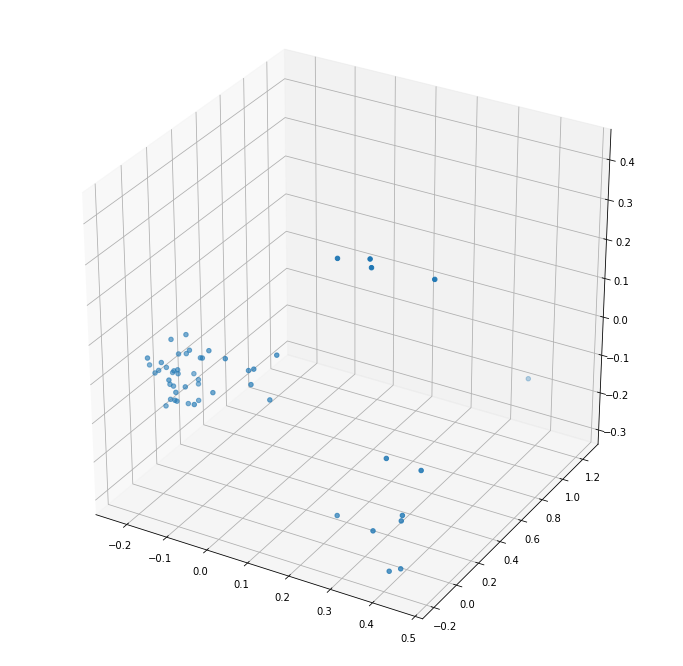

In [19]:
from mpl_toolkits.mplot3d import Axes3D

pca=PCA(n_components=3)
X_reduced=pca.fit_transform(X)
print(X_reduced.shape)

plt.figure(figsize=(12,12))
ax = plt.axes(projection='3d')
ax.scatter(np.array(X_reduced[:,0]),np.array(X_reduced[:,1]),np.array(X_reduced[:,2]))

On voit que meme dans une representation en 2D/3D  où beaucoup d'information a été perdue par reduction de dimension on arrive a voir le cluster des images principales et les outliers.

Le nombre de Cluster trouvés:  6


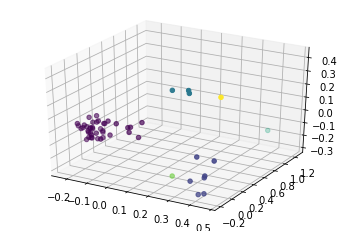

In [22]:
from sklearn.cluster import MeanShift
cluster=MeanShift()
cluster.fit(X)
Y=cluster.predict(X)
print("Le nombre de Cluster trouvés: ",len(set(Y)))
ax = plt.axes(projection='3d')
ax.scatter(np.array(X_reduced[:,0]),np.array(X_reduced[:,1]),np.array(X_reduced[:,2]),c=Y)

Regardons la distribution des images sur les differents clusters.

(array([40.,  0.,  7.,  0.,  3.,  0.,  1.,  0.,  1.,  1.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 10 Patch objects>)

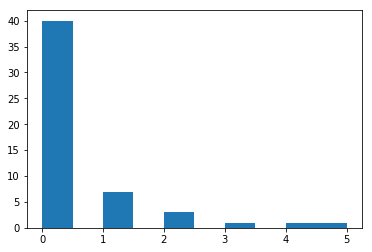

In [23]:
plt.hist(Y)

On voit que l'on a un cluster principal qui contient les photos positives.Verifions le nombre d'outliers trouvés par cette methode.

In [26]:
print("le nombre d'outliers trouvés est :"+str(np.sum(Y!=0)))


le nombre d'outliers trouvés est :13


On voit que la methode Meanshift marche tres bien pour ce dossier.

Essayons des dossiers plus difficiles.

Nous choisissons le dossier Ben Rhodes où il n'y as que deux outliers 

vide
vide
vide
vide


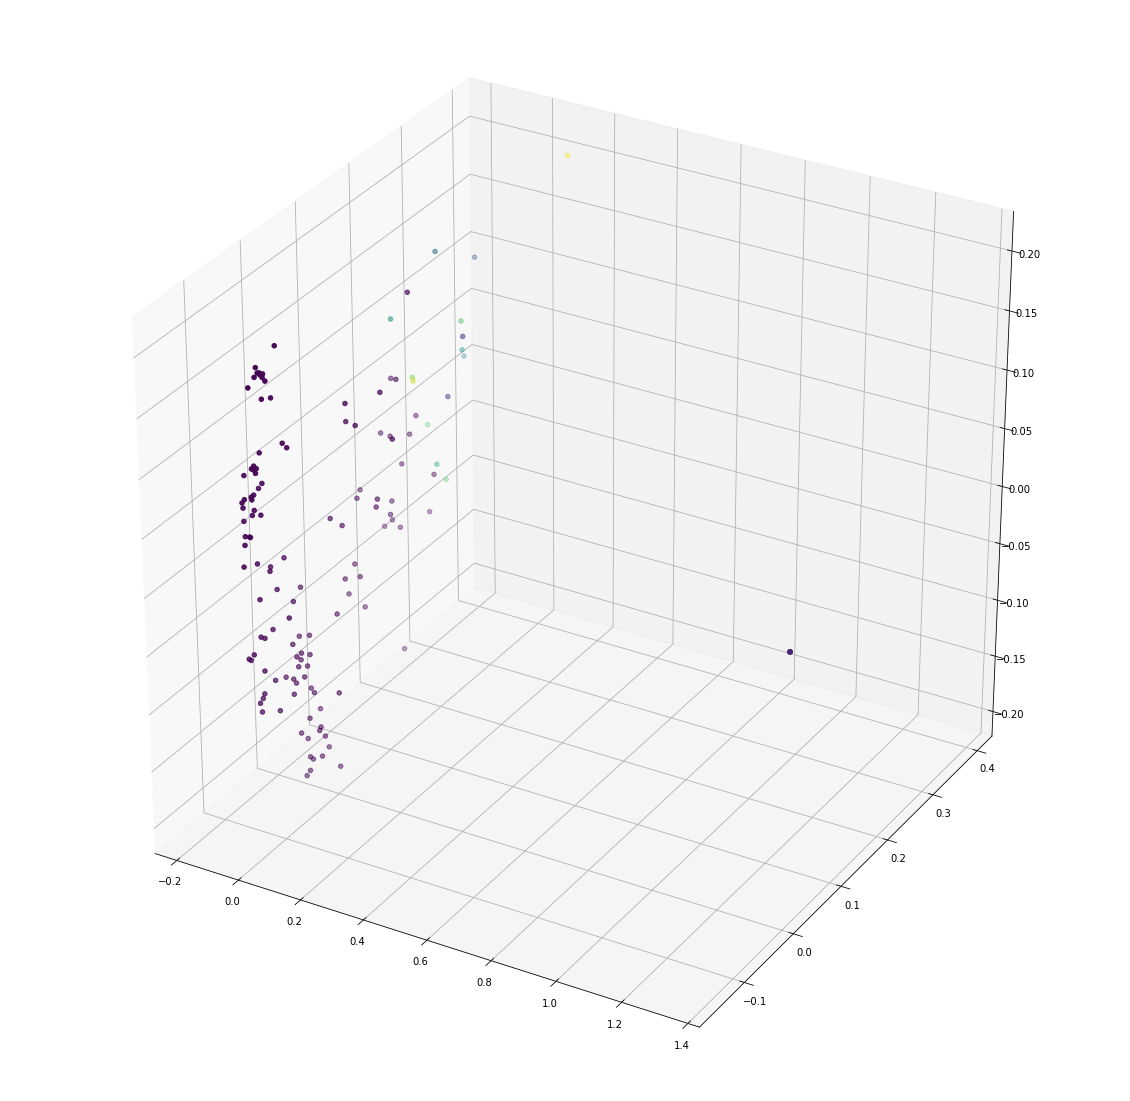

In [27]:
name="ben rhodes"

num_pictures=len(Dict[name].keys())

X=np.zeros((num_pictures,128))

for i in range(num_pictures):
    
    if Dict[name][i]!=[]:
        
        X[i]=Dict[name][i][0]
    else:
        print("vide")
        X[i]=np.zeros((128))
pca=PCA(n_components=3)
X_reduced=pca.fit_transform(X)
plt.figure(figsize=(20,20))
from sklearn.cluster import MeanShift
cluster=MeanShift()
cluster.fit(X)
Y=cluster.predict(X)
ax = plt.axes(projection='3d')
ax.scatter(np.array(X_reduced[:,0]),np.array(X_reduced[:,1]),np.array(X_reduced[:,2]),c=Y)

Le nombre de Cluster trouvés:  12


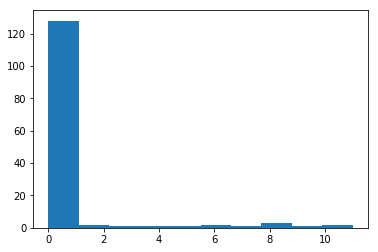

In [30]:
plt.hist(Y)
print("Le nombre de Cluster trouvés: ",len(set(Y)))



In [29]:
print("le nombre d'outliers trouvés est :"+str(np.sum(Y!=0)))


le nombre d'outliers trouvés est :18


Nous voyons que l'algorithme detecte 18 outliers ce qui est beaucoup plus que ce que nous avions decelé à la main.
verifions cette tendance vers les faux negatifs dans le cas d'un dossier où il n'y a pas d'outliers.

Nous considerons le dossier de Constance Wu où nous n'avons trouvé aucun outlier.

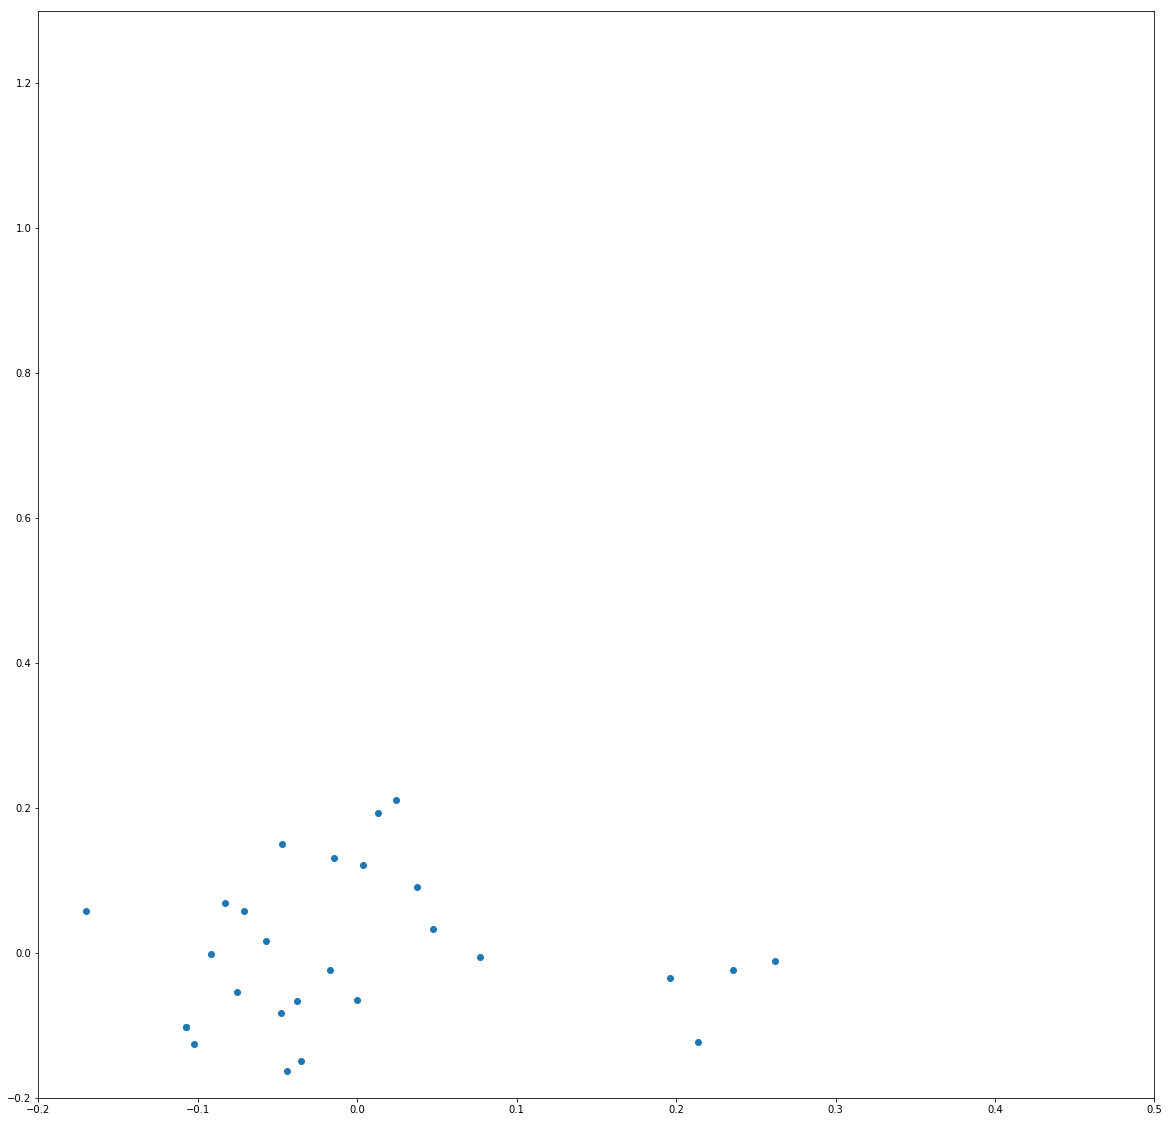

In [46]:
name="constance wu"

num_pictures=len(Dict[name].keys())

X=np.zeros((num_pictures,128))
plt.figure(figsize=(20,20))

for i in range(num_pictures):
    
    if Dict[name][i]!=[]:
        
        X[i]=Dict[name][i][0]
    else:
        print("vide")
        X[i]=np.zeros((128))
pca=PCA(n_components=2)
X_reduced=pca.fit_transform(X)
plt.axis((-0.2,0.5,-0.2,1.3))
plt.scatter(np.array(X_reduced[:,0]),np.array(X_reduced[:,1]))

Nous rappelons ici un autre defaut de Face_recognition puisque l'encodage genere en 2D quatre points trés eloignées des données principales.Des points qui seront surement considéré comme outliers.


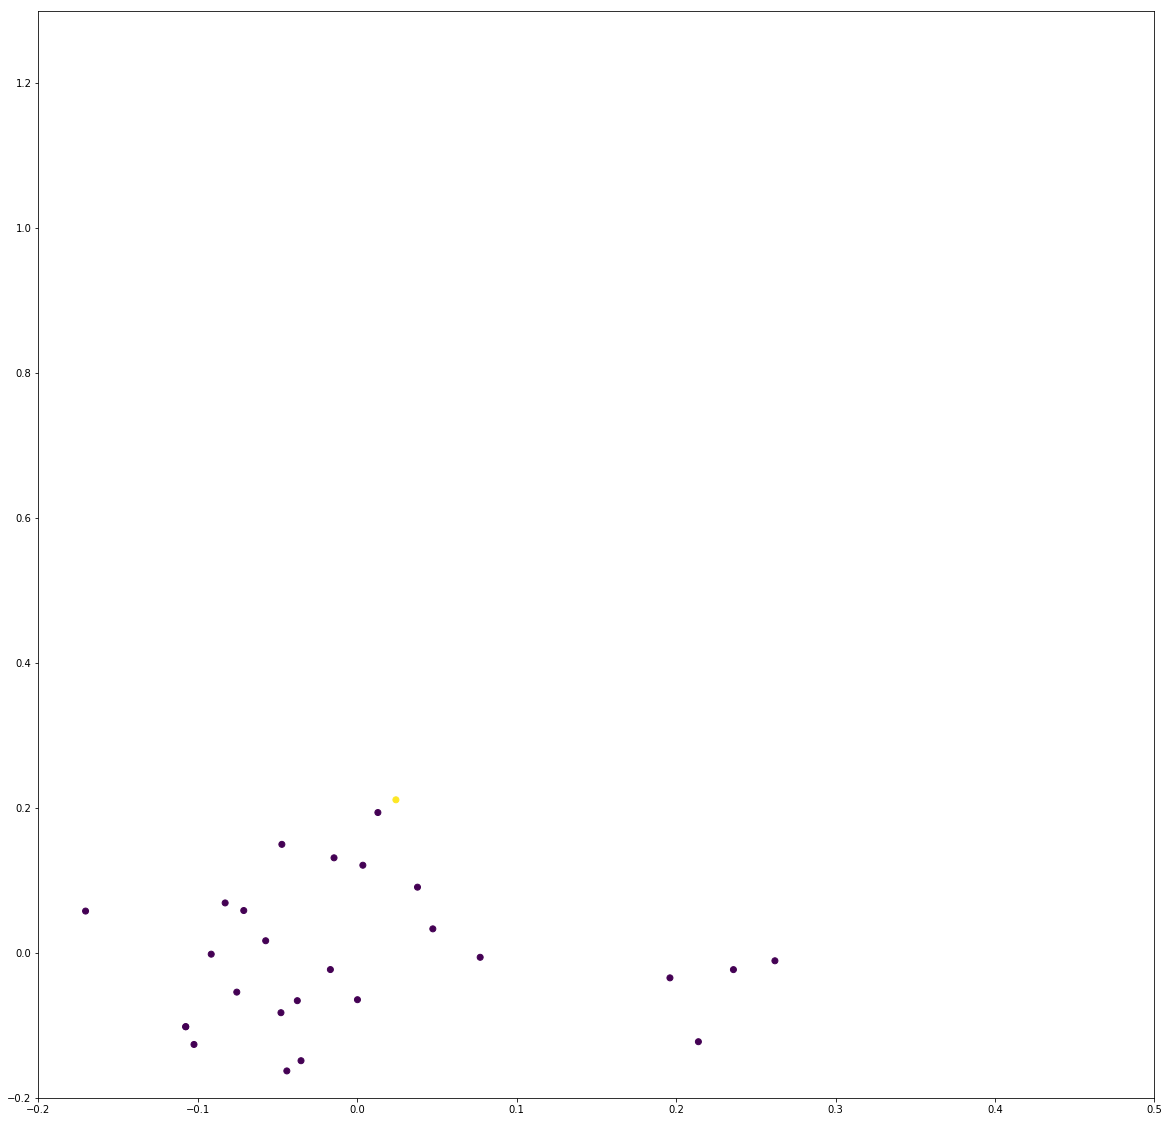

In [32]:
plt.figure(figsize=(20,20))
from sklearn.cluster import MeanShift
cluster=MeanShift()
cluster.fit(X)
Y=cluster.predict(X)
plt.axis((-0.2,0.5,-0.2,1.3))
plt.scatter(np.array(X_reduced[:,0]),np.array(X_reduced[:,1]),c=Y)

Le nombre de Cluster trouvés:  2
le nombre d'outliers trouvés est :1


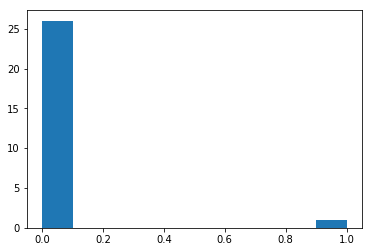

In [33]:
plt.hist(Y)
print("Le nombre de Cluster trouvés: ",len(set(Y)))
print("le nombre d'outliers trouvés est :"+str(np.sum(Y!=0)))


On voit que Meanshift parvient a depassé le probleme de representation soulevé par Face_recognition.Il classifier les 4 points que Kmeans avait considéré comme outliers .Mais on voit que l'algorithme garde cette tendance vers le faux negatif puisqu'il definit un point comme etant outlier alors qu'il fait visiblement partie du cluster principal.

## Comment regler le probleme de la tendance aux faux negatifs?

Une idée pour regler le probleme des faux negatifs est de rentre nos cluster plus permissif et donc plus large.Il semblerait donc falloir augmenter la largeur de bande de notre algorithm.

La largeur de bande utilisée par defaut par MeanShift est une estimation faite par la fonction :

sklearn.cluster.estimate_bandwidth

In [37]:
from sklearn.cluster import estimate_bandwidth
print(estimate_bandwidth(X))
print(estimate_bandwidth(X,quantile=0.5))
print(estimate_bandwidth(X,quantile=1))


0.36889966432795435
0.4003600074229323
0.5191710455309011


On voit qu'en augmentant le parametre "Quantile" permet d'augmenter la largeur de bande.Essayons cette approche sur notre dossier sans outliers.

In [112]:
quant=0.6

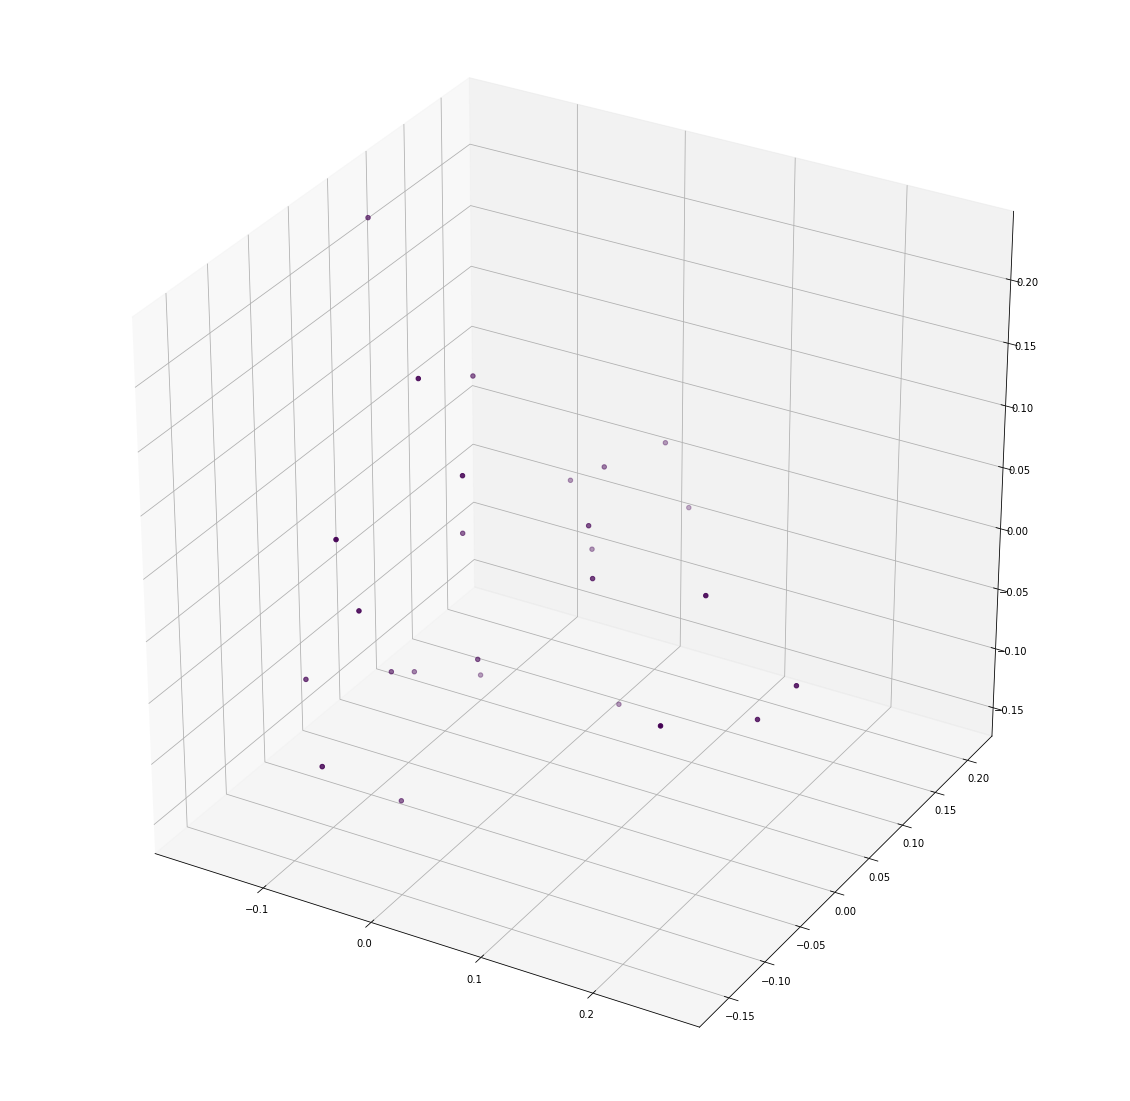

In [101]:
name="constance wu"



num_pictures=len(Dict[name].keys())

X=np.zeros((num_pictures,128))

for i in range(num_pictures):
    
    if Dict[name][i]!=[]:
        
        X[i]=Dict[name][i][0]
    else:
        print("vide")
        X[i]=np.zeros((128))
pca=PCA(n_components=3)
X_reduced=pca.fit_transform(X)
plt.figure(figsize=(20,20))
from sklearn.cluster import MeanShift
cluster=MeanShift(estimate_bandwidth(X,quantile=quant))
cluster.fit(X)
Y=cluster.predict(X)
ax = plt.axes(projection='3d')
ax.scatter(np.array(X_reduced[:,0]),np.array(X_reduced[:,1]),np.array(X_reduced[:,2]),c=Y)

Le nombre de Cluster trouvés:  1
le nombre d'outliers trouvés est :0


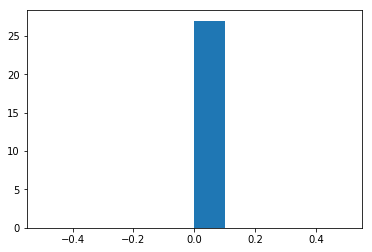

In [102]:
plt.hist(Y)
print("Le nombre de Cluster trouvés: ",len(set(Y)))
print("le nombre d'outliers trouvés est :"+str(np.sum(Y!=0)))


On voit qu'augmenter la largeur de bande a élminer le probleme du faux negatifs dans le cas de ce dossier

vide
vide
vide
vide


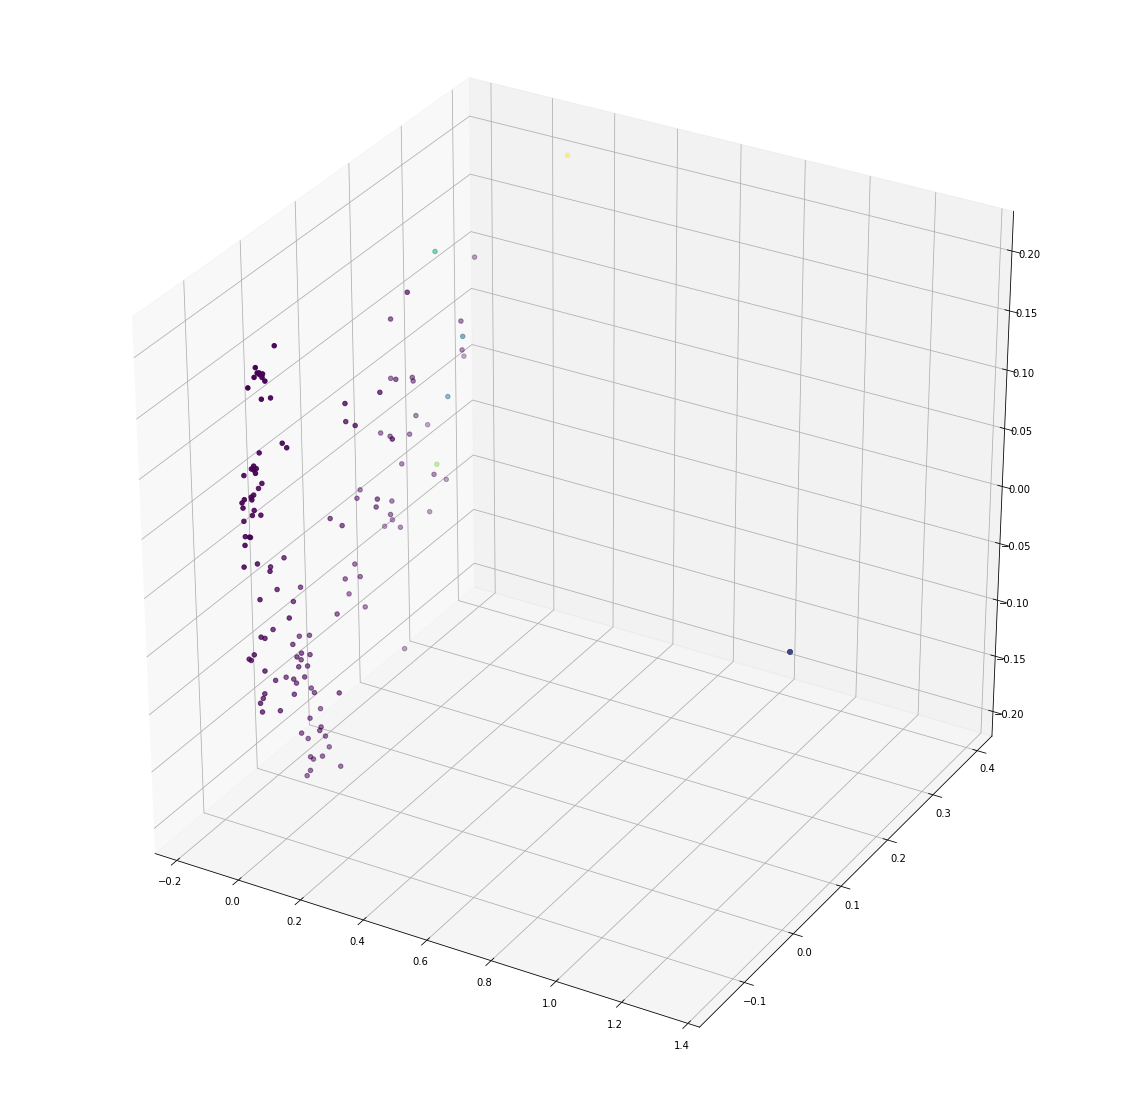

In [113]:
name="ben rhodes"

num_pictures=len(Dict[name].keys())

X=np.zeros((num_pictures,128))

for i in range(num_pictures):
    
    if Dict[name][i]!=[]:
        
        X[i]=Dict[name][i][0]
    else:
        print("vide")
        X[i]=np.zeros((128))
pca=PCA(n_components=3)
X_reduced=pca.fit_transform(X)
plt.figure(figsize=(20,20))
from sklearn.cluster import MeanShift
cluster=MeanShift(estimate_bandwidth(X,quantile=quant))
cluster.fit(X)
Y=cluster.predict(X)
ax = plt.axes(projection='3d')
ax.scatter(np.array(X_reduced[:,0]),np.array(X_reduced[:,1]),np.array(X_reduced[:,2]),c=Y)

Le nombre de Cluster trouvés:  6
le nombre d'outliers trouvés est :9


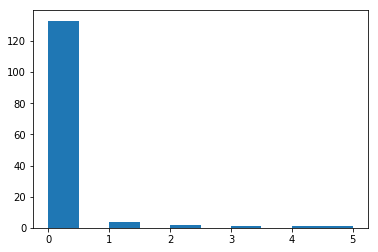

In [114]:
plt.hist(Y)
print("Le nombre de Cluster trouvés: ",len(set(Y)))
print("le nombre d'outliers trouvés est :"+str(np.sum(Y!=0)))

L'augmentation de largeur de bande permet d'attenuer le probleme sur le dossier Ben Rhodes

la photo numero 42 de rafael benítez  genere un encodage vide


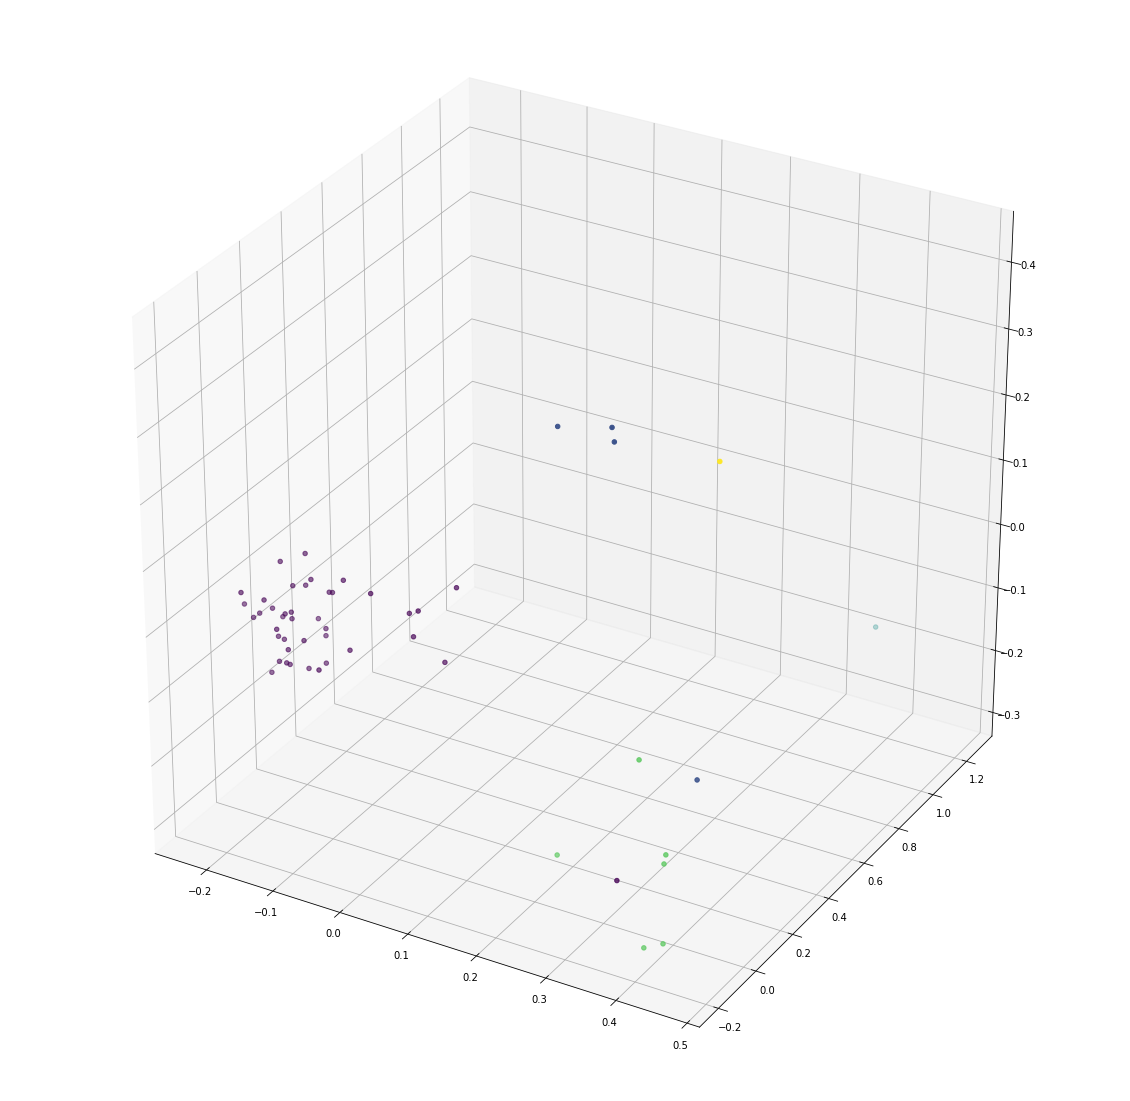

In [110]:
name="rafael benítez"

num_pictures=len(Dict[name].keys())

X=np.zeros((num_pictures,128))

for i in range(num_pictures):
    
    if Dict[name][i]!=[]:
        
        X[i]=Dict[name][i][0]
    else:
        print("la photo numero "+str(i)+" de "+name+"  genere un encodage vide")
        X[i]=np.zeros((128))

pca=PCA(n_components=3)
X_reduced=pca.fit_transform(X)
plt.figure(figsize=(20,20))
from sklearn.cluster import MeanShift
cluster=MeanShift(estimate_bandwidth(X,quantile=quant))
cluster.fit(X)
Y=cluster.predict(X)
ax = plt.axes(projection='3d')
ax.scatter(np.array(X_reduced[:,0]),np.array(X_reduced[:,1]),np.array(X_reduced[:,2]),c=Y)


Le nombre de Cluster trouvés:  5
le nombre d'outliers trouvés est :12


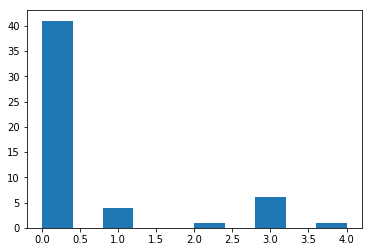

In [111]:
plt.hist(Y)
print("Le nombre de Cluster trouvés: ",len(set(Y)))
print("le nombre d'outliers trouvés est :"+str(np.sum(Y!=0)))

Cette largeur de bande n'altere pas les performances sur le dossier où l'on avait pas de probleme de faux negatifs.

### Conclusions sur la largeur de bande:

d'apres ces tests on peut esperer à travers une recherche d'hyperparametres trouver une valeur de largeur de bande satisfaisante pour tout les dossiers de la base de données.Le choix de cet hyper parametre sera guidé par la metrique de precision representative que nous avons choisi.

# Evaluation finale de Meanshift sur nos données: